In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../")

from jumpmodels import *
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# random seed
from numpy.random import RandomState
random_state = RandomState(RANDOM_STATE)

# Load Data & Features

First, we load both the raw data and the engineered features. It's important to note that the presented feature set serves solely for illustrative purposes. There is no assurance that this feature set is optimal. As with any statistical or machine learning algorithm, feature engineering plays a crucial role in achieving satisfactory performance. Users are strongly encouraged to customize the features to suit their specific application.

In [2]:
df = pd.read_pickle("data.pkl")
ret = df.ret
X = load_example_features(ret)
print(df.tail())
print(X.tail())

                     prc       ret
date                              
2024-04-15  15885.019531 -0.017933
2024-04-16  15865.250000 -0.001245
2024-04-17  15683.370117 -0.011464
2024-04-18  15601.500000 -0.005220
2024-04-19  15282.009766 -0.020478
               vol_5    vol_15    vol_45     ret_5    ret_15    ret_45
date                                                                  
2024-04-15  0.011800  0.010330  0.010143 -0.002934 -0.000393  0.000788
2024-04-16  0.011025  0.010096  0.010069 -0.002715 -0.000431  0.000757
2024-04-17  0.010728  0.010134  0.010104 -0.003848 -0.000929  0.000570
2024-04-18  0.010021  0.009944  0.010052 -0.004025 -0.001123  0.000481
2024-04-19  0.010963  0.010533  0.010303 -0.006155 -0.001997  0.000161


In [3]:
START, END = "1990-1-1", "2002-1-1"
X_train = filter_date_range(X, START, END)
ret_ser_train = filter_date_range(ret, START, END)
scaler = StandardScaler()
X_train_standard = raise_arr_to_pd_obj(scaler.fit_transform(X_train), X_train, columns_key="columns", return_as_ser=False)

# Baseline Methods

For comparison, we initially fit the data using a baseline model, which is the $k$-means clustering. It's important to note that the fitted regimes lack persistence and exhibit numerous jumps.

In [4]:
kmeans = KMeans(3, n_init=10, tol=1e-8, max_iter=1000, random_state=RANDOM_STATE+1)
kmeans.fit(X_train_standard)

KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=1, tol=1e-08)

<Axes: title={'center': '$k$-means Clustering Regime Labels, # of regime shifts: 103'}, ylabel='regime'>

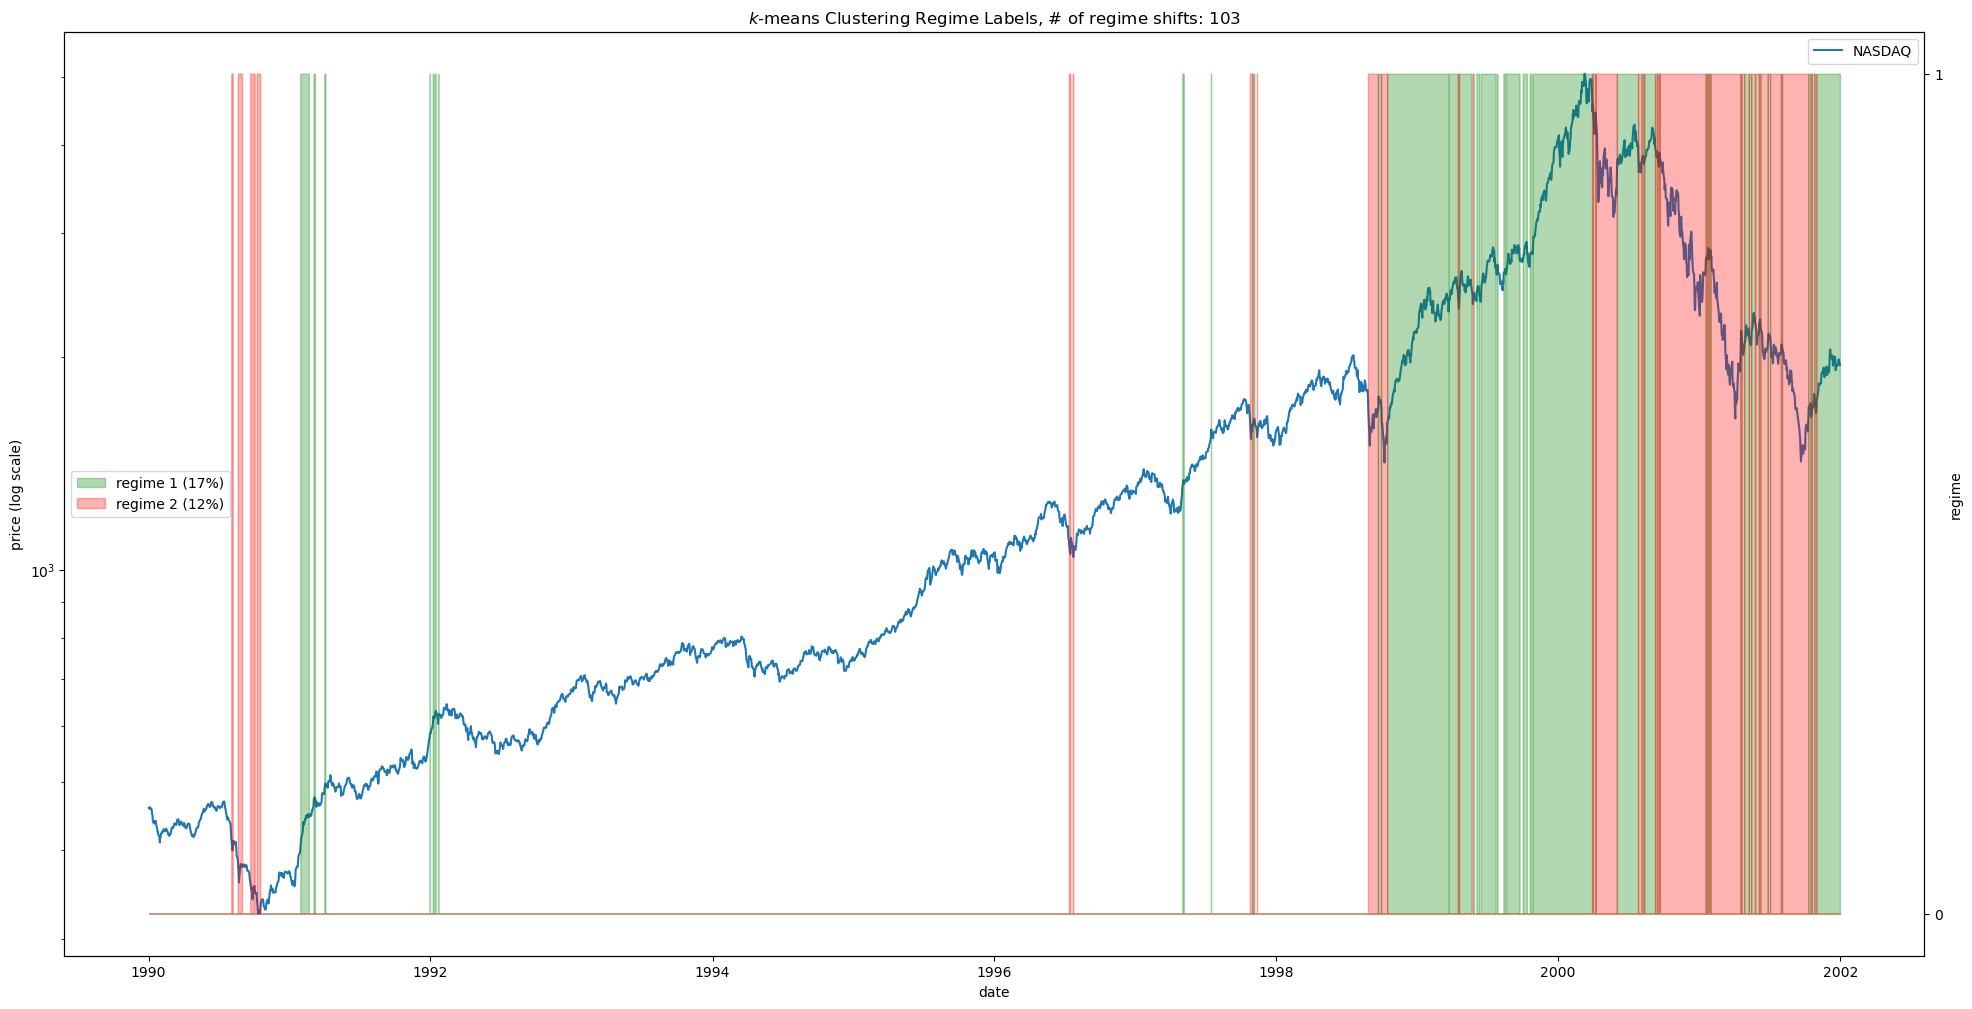

In [5]:
ax=check_axes()
filter_date_range(pd.DataFrame({"NASDAQ": df.prc}), START, END).plot(ax=ax)
ax.set(ylabel="price (log scale)", yscale="log")
ax2 = ax.twinx()
plot_regime(raise_arr_to_pd_obj(kmeans.labels_, ret_ser_train), ax=ax2, title=r"$k$-means Clustering Regime Labels")

# In-sample Fitting of JMs & CJMs

Subsequently, we fit the Jump Models (JMs) and Composite Jump Models (CJMs) in-sample. It's worth mentioning that the jump penalty inputted here is somewhat arbitrary and serves solely for illustrative purposes. This crucial hyperparameter controls the desired level of persistence and is recommended to be chosen in a train-validation-test cross-validation setting, tailored to downstream applications such as portfolio construction.

Despite the challenge of selecting the jump penalty, we observe a significant improvement in the persistence of the inferred regime sequence.

In [6]:
# discrete JM
jm = JumpModel(3, 1e2, random_state=RANDOM_STATE).fit(X_train_standard, ret_ser_train, sort_by="vol")
# CJM w/ mode loss
cjm_mode = JumpModel(3, 1e3, cont=True, random_state=RANDOM_STATE, verbose=True).fit(X_train_standard, ret_ser_train, sort_by="vol")
# CJM w/o mode loss
cjm_no_mode = JumpModel(3, 1e3, cont=True, mode_loss=False, random_state=RANDOM_STATE, verbose=True).fit(X_train_standard, ret_ser_train, sort_by="vol")

0-th init. val: 4496.373961135983
1-th init. val: 4496.373961135983
2-th init. val: 5244.197181383882
3-th init. val: 4496.373961135983
4-th init. val: 4496.373961135983
5-th init. val: 4493.919737694364
6-th init. val: 5244.197181383882
7-th init. val: 4496.373961135983
8-th init. val: 4496.373961135983
9-th init. val: 5244.197181383882
5-th init has the best value: 4493.919737694364.
0-th init. val: 4481.322188396539
1-th init. val: 4481.322188396539
2-th init. val: 5226.66455165435
3-th init. val: 4481.322188396539
4-th init. val: 4481.322188396539
5-th init. val: 4483.885222534729
6-th init. val: 5226.66455165435
7-th init. val: 4481.322188396539
8-th init. val: 4481.322188396539
9-th init. val: 5226.66455165435
0-th init has the best value: 4481.322188396539.


<Axes: title={'center': 'CJM (with mode loss)-inferred Regime Probabilites, $\\lambda$=1000.0, # of regime shifts: 4'}, ylabel='regime'>

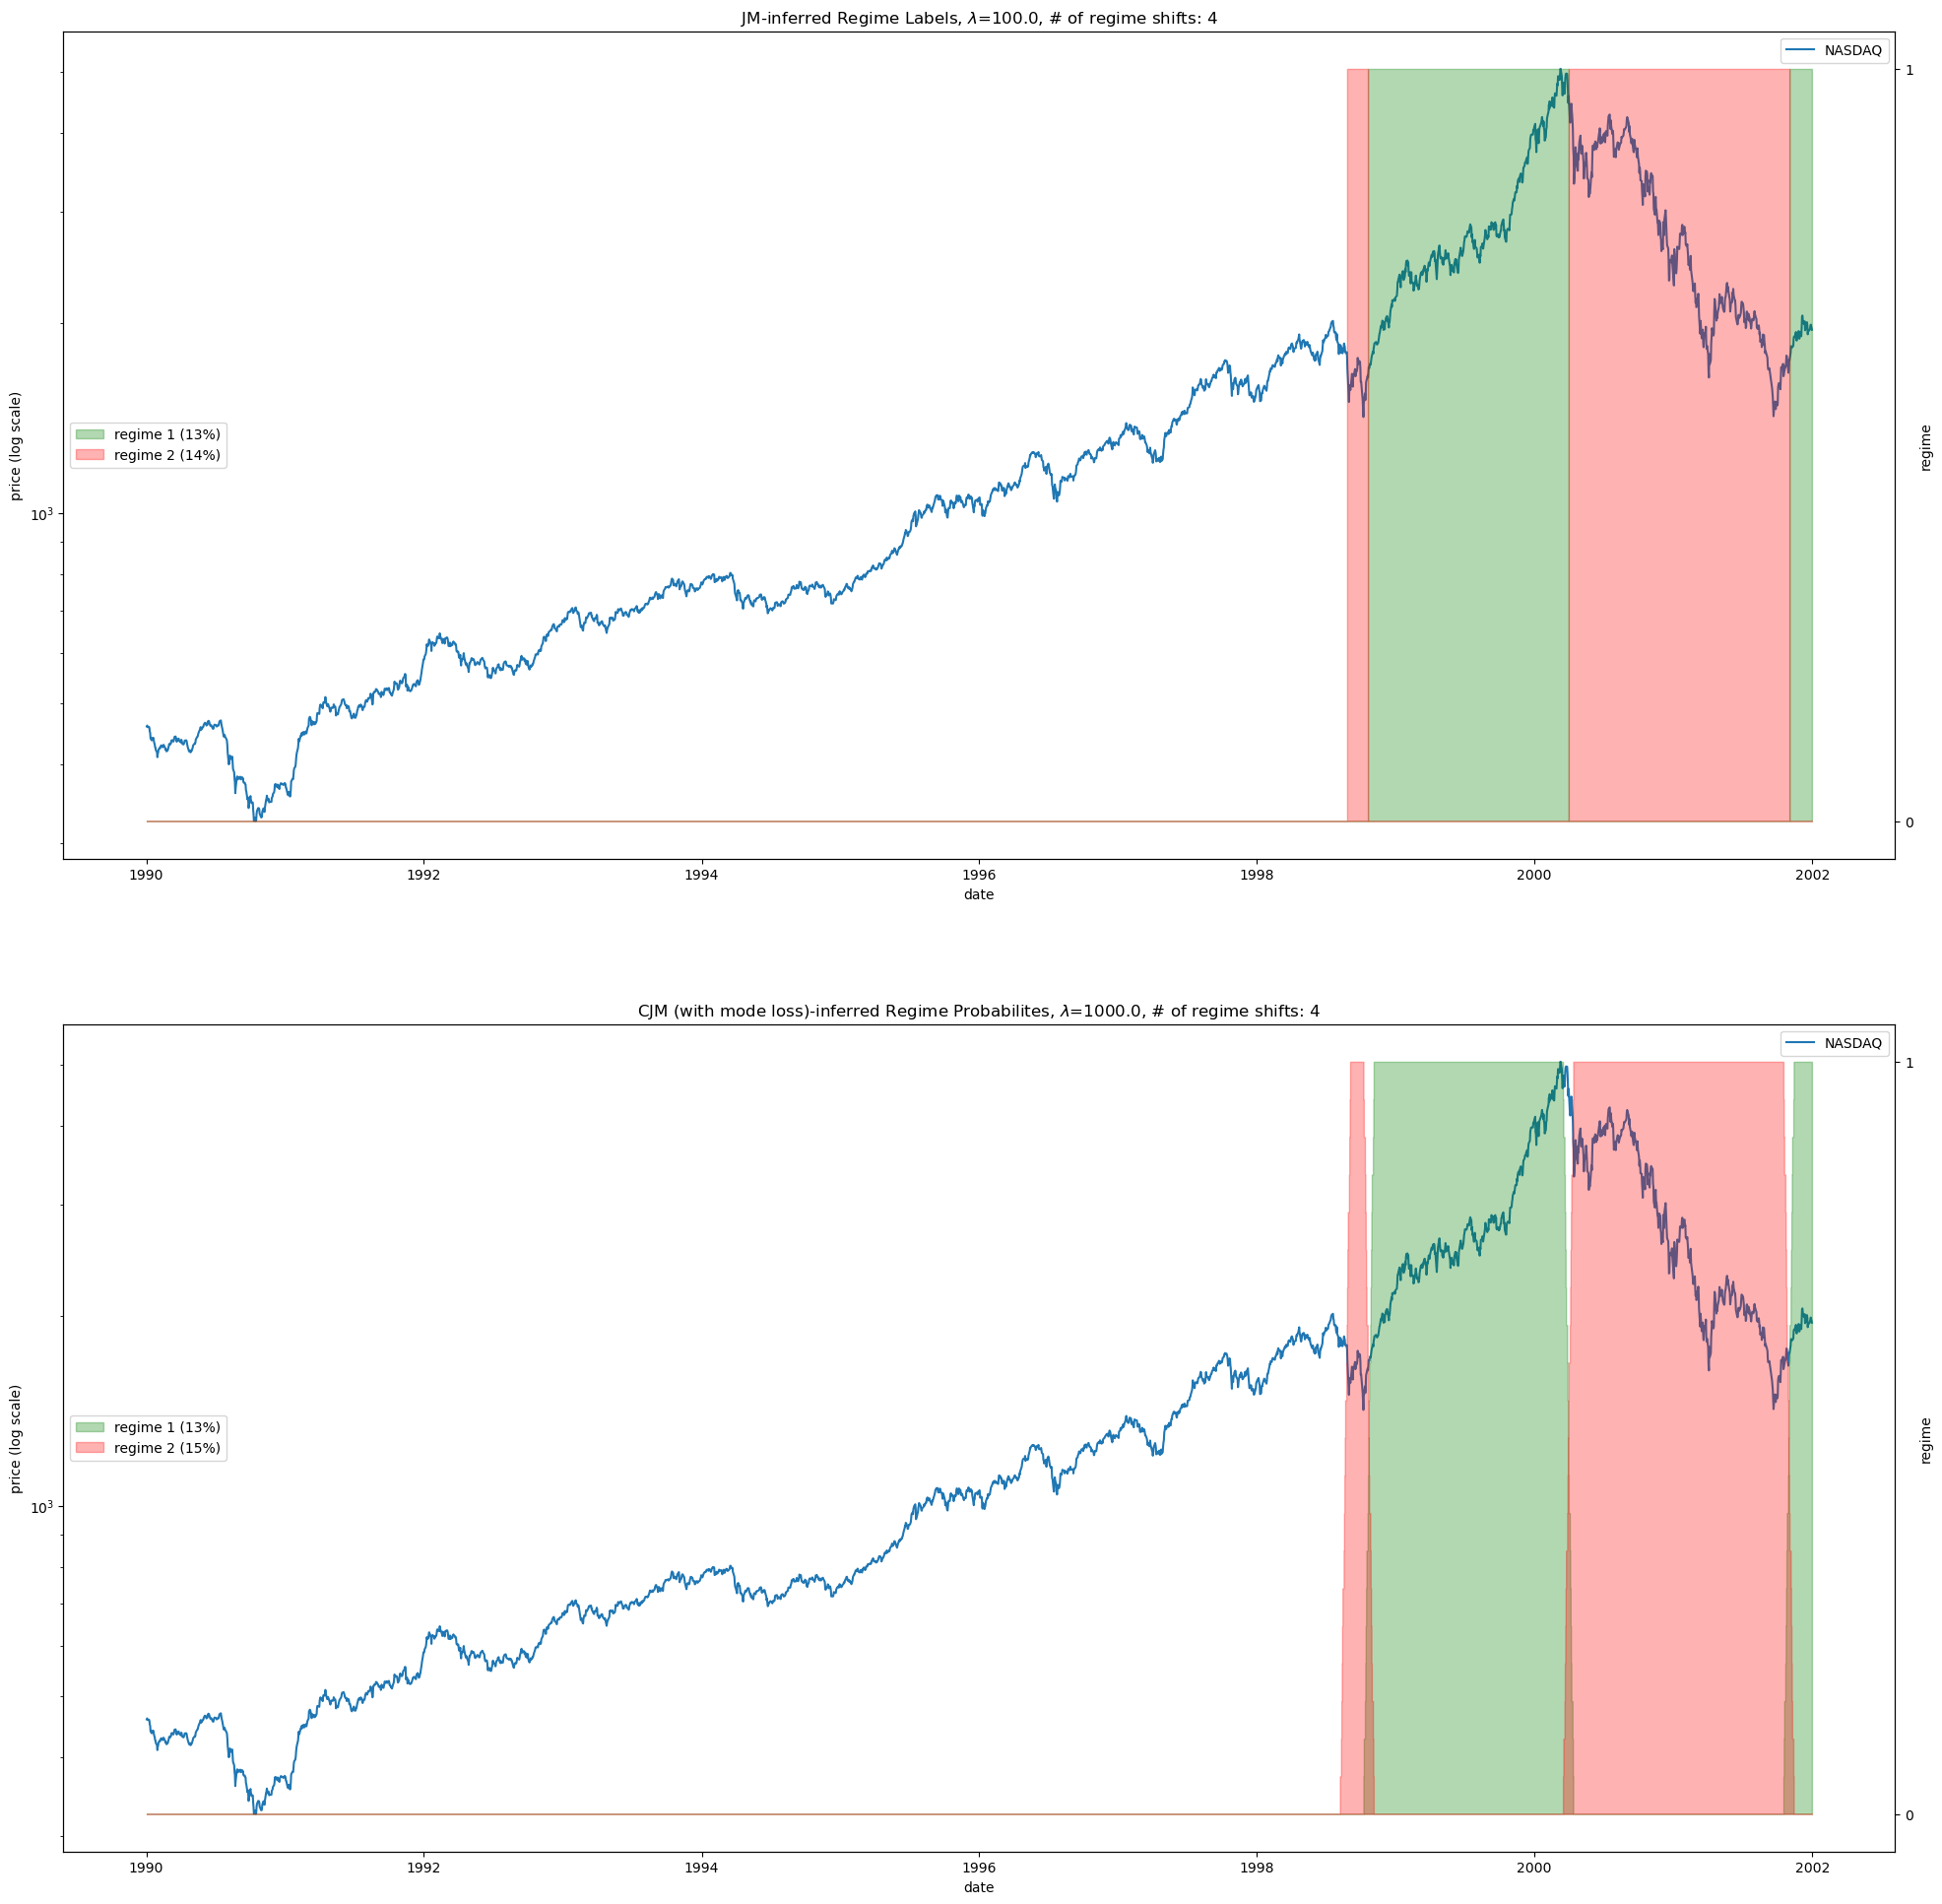

In [7]:
ax = check_axes(nrows=2)
i=0
filter_date_range(pd.DataFrame({"NASDAQ": df.prc}), START, END).plot(ax=ax[i])
ax[i].set(ylabel="price (log scale)")
ax2 = ax[i].twinx()
plot_regime(jm.labels_, ax=ax2, title=r"JM-inferred Regime Labels, $\lambda$=100.0")
ax[i].set(yscale="log")
i=1
filter_date_range(pd.DataFrame({"NASDAQ": df.prc}), START, END).plot(ax=ax[i])
ax[i].set(ylabel="price (log scale)", yscale="log")
ax2 = ax[i].twinx()
plot_regime(cjm_mode.proba_, ax=ax2, title=r"CJM (with mode loss)-inferred Regime Probabilites, $\lambda$=1000.0")

# Out-of-sample Fitting

Lastly, we demonstrate how to perform out-of-sample prediction using jump models. It's worth noting that the in-sample and out-of-sample jump penalty may differ. We reiterate the importance of prudent and meticulous tuning of these hyperparameters.

The usefulness of the out-of-sample clustering results depends largely on how they are applied to downstream trading applications.

In [8]:
END = "2022-1-1"
X_train = filter_date_range(X, START, END)
ret_ser_train = filter_date_range(ret, START, END)
scaler = StandardScaler()
X_train_standard = raise_arr_to_pd_obj(scaler.fit_transform(X_train), X_train, columns_key="columns", return_as_ser=False)
X_test = filter_date_range(X, start_date="2020-1-1")
X_test_standard = raise_arr_to_pd_obj(scaler.transform(X_test), X_test, columns_key="columns", return_as_ser=False)

In [9]:
jm.fit(X_train_standard, ret_ser_train, sort_by="vol")

JumpModel(jump_penalty=100.0, n_components=3, random_state=0)

In [10]:
# set oos lambd
jm.set_params(jump_penalty=50.0).check_jump_penalty_mx()

array([[ 0., 50., 50.],
       [50.,  0., 50.],
       [50., 50.,  0.]])

In [11]:
labels_oos_jm = filter_date_range(jm.predict_proba_online(X_test_standard).shift(), start_date=END)

<Axes: title={'center': 'JM-inferred Out-of-sample Regime Probabilites, $\\lambda_{\\text{is}}$=100.0, $\\lambda_{\\text{oos}}$=50.0, # of regime shifts: 5'}, ylabel='regime'>

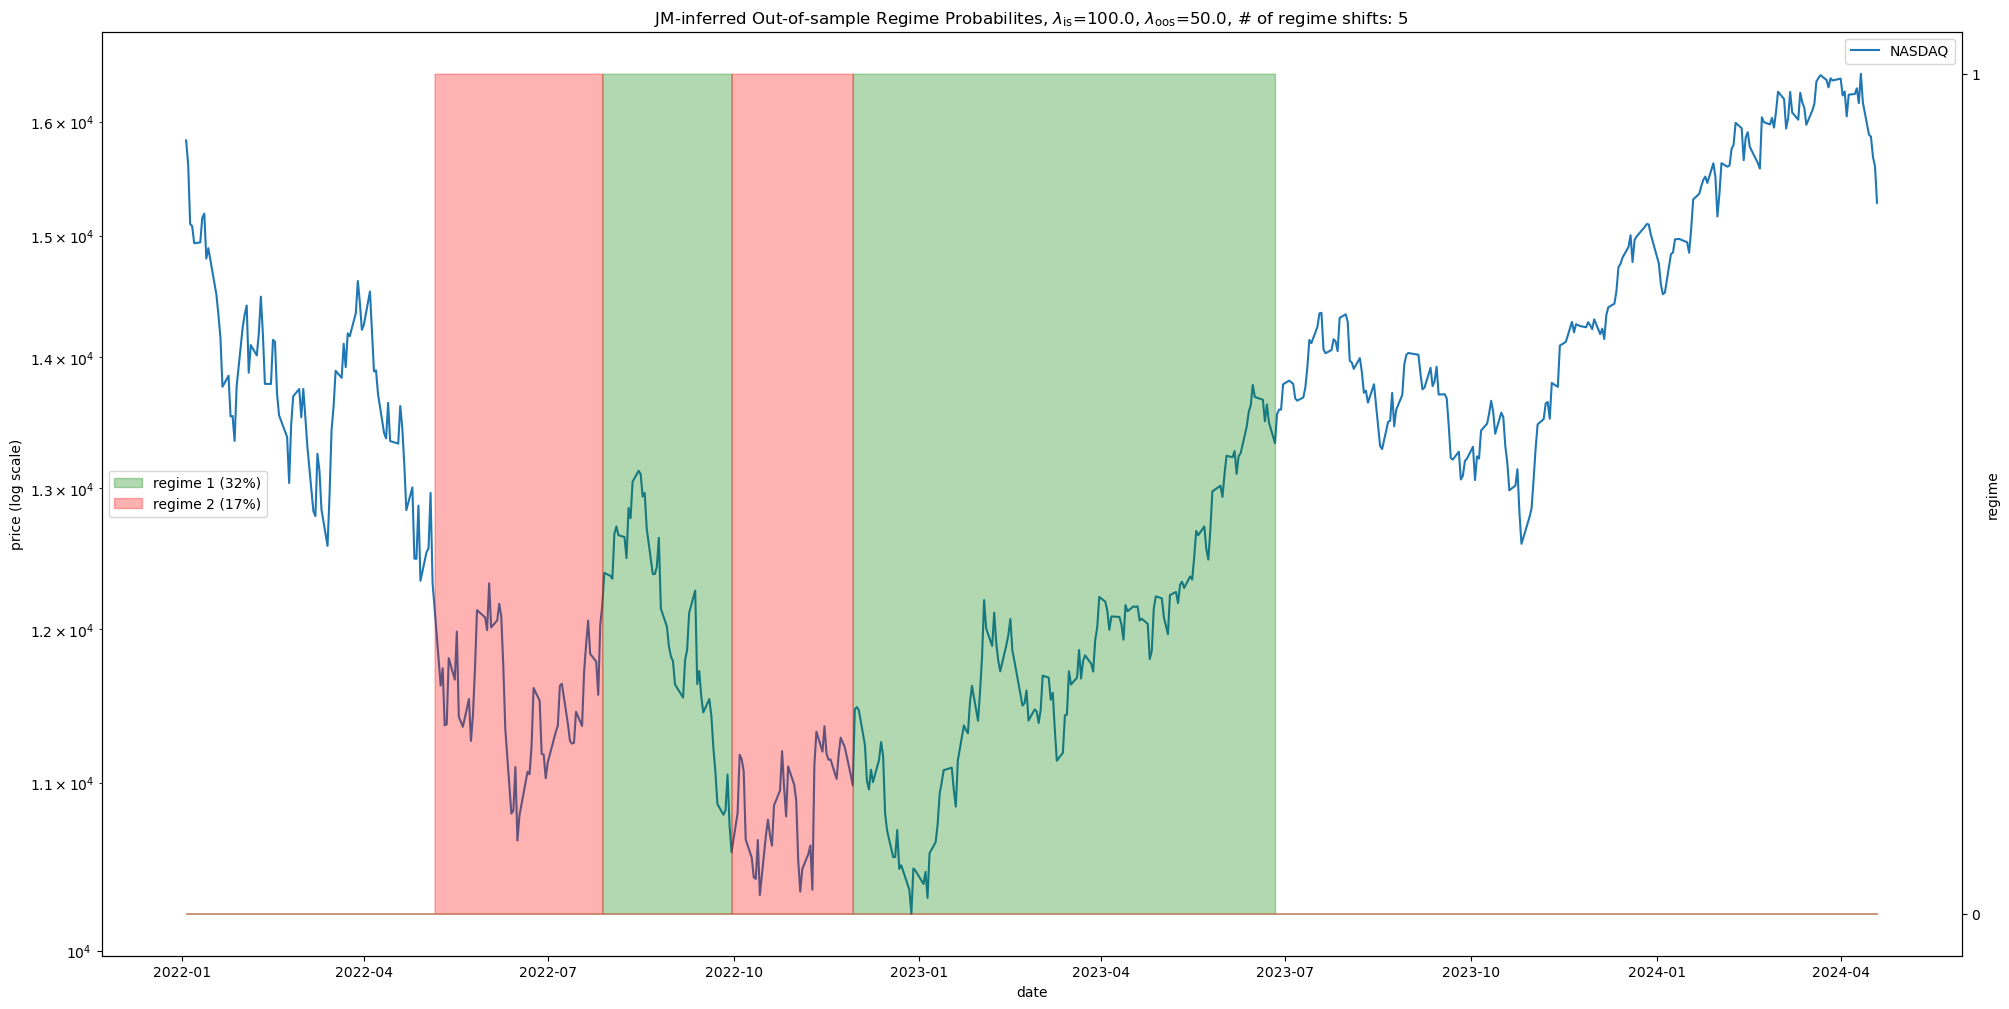

In [12]:
ax = check_axes()
filter_date_range(pd.DataFrame({"NASDAQ": df.prc}), END).plot(ax=ax)
ax.set(ylabel="price (log scale)", yscale="log")
ax2 = ax.twinx()
plot_regime(labels_oos_jm, ax=ax2, title=r"JM-inferred Out-of-sample Regime Probabilites, $\lambda_{\text{is}}$=100.0, $\lambda_{\text{oos}}$=50.0")